# Các thư viện sử dụng

In [ ]:
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Tạo Datasets

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

In [ ]:
n = 60000
m = 60000

#in domain
x1 = 20*np.random.rand(int(n/4),1)
y1 = 2*np.random.rand(int(n/4),1)
data = np.concatenate((x1,y1),axis = 1)

x2_01 = 20*np.random.rand(int(m/4),1)
y2_01 = 2*np.zeros((int(m/4),1))
x2_10 = 20*np.ones((int(m/4),1))
y2_10 = 2*np.random.rand(int(m/4),1)
x2_11 = 20*np.random.rand(int(m/4),1)
y2_11 = 2*np.ones((int(m/4),1))

data2 = np.concatenate((x2_01,y2_01),axis = 1)
data3 = np.concatenate((x2_10,y2_10),axis = 1)
data2 = np.concatenate((data2,data3),axis = 0)
data3 = np.concatenate((x2_11,y2_11),axis = 1)
data2 = np.concatenate((data2,data3),axis = 0)
data2 = np.concatenate((data2,data),axis = 0)

#on Dirichlet boundary

x2_00 = 20*np.zeros((m,1))
y2_00 = 2*np.random.rand(m,1)
data = np.concatenate((x2_00,y2_00),axis = 1)

data = np.concatenate((data2,data),axis = 1).astype('float32')
np.random.shuffle(data)

# Tạo các hàm sử dụng

In [ ]:
class Model(tf.keras.Model):
  def __init__(self):
    super(Model,self).__init__()
    self.model1 = keras.Sequential([
        layers.Dense(2, activation="tanh"),
        layers.Dense(50, activation="tanh"),
        layers.Dense(50, activation="tanh"),
        layers.Dense(50, activation="tanh"),
        layers.Dense(1)
    ])
    self.model2 = keras.Sequential([
        layers.Dense(2, activation="tanh"),
        layers.Dense(50, activation="tanh"),
        layers.Dense(50, activation="tanh"),
        layers.Dense(50, activation="tanh"),
        layers.Dense(1)
    ])

  def call(self,x):
    output1 = self.model1(x)
    output2 = self.model2(x)
    return output1,output2

PINN = Model()

In [ ]:
def func(n):
  return -500*tf.ones(n)

In [ ]:
def grad(x,model):
  with tf.GradientTape(persistent = True) as tape:
    tape.watch(x)
    u1,u2 = model(x)
  
  u1_x1 = tape.gradient(u1,x)[:,0]
  u1_x2 = tape.gradient(u1,x)[:,1]
  u2_x1 = tape.gradient(u2,x)[:,0]
  u2_x2 = tape.gradient(u2,x)[:,1]

  return u1,u2,u1_x1,u1_x2,u2_x1,u2_x2

In [ ]:
def train(data,batch_size,model,optimizer,epochs,f,lamb,mu):
  if (optimizer == 'adam'):
    optimizer = tf.keras.optimizers.Adam()
    P_in = data[:,0:2]
    P_on = data[:,2:4]
    k = int(n/batch_size)
    for epoch in range(epochs):
      print("Epoch: "+ str(epoch+1))
      loss = 0
      for i in range(k):
        P_i = tf.convert_to_tensor(P_in[batch_size*i:batch_size*(i+1),:])
        P_o = tf.convert_to_tensor(P_on[batch_size*i:batch_size*(i+1),:])
        with tf.GradientTape() as tape:
          with tf.GradientTape(persistent=True) as tape2:
            tape2.watch(P_i)
            u1,u2,u1_x1,u1_x2,u2_x1,u2_x2 = grad(P_i,model)
          
          #second-order gradient
          u1_x1x1 = tape2.gradient(u1_x1,P_i)[:,0]
          u1_x1x2 = tape2.gradient(u1_x1,P_i)[:,1]
          u1_x2x2 = tape2.gradient(u1_x2,P_i)[:,1]
          u2_x1x1 = tape2.gradient(u2_x1,P_i)[:,0]
          u2_x1x2 = tape2.gradient(u2_x1,P_i)[:,1]
          u2_x2x2 = tape2.gradient(u2_x2,P_i)[:,1]
          f2 = f(batch_size)
          f1 = tf.zeros_like(f2)
          
          #loss in domain
          loss_in1 = tf.math.square(mu*(u1_x1x1+u1_x2x2)+(mu+lamb)*(u1_x1x1+u2_x1x2)+f1)
          loss_in2 = tf.math.square(mu*(u2_x1x1+u2_x2x2)+(mu+lamb)*(u1_x1x2+u2_x2x2)+f2)
          loss_in = tf.reduce_mean(tf.math.sqrt(loss_in1 + loss_in2))

          #loss_on_boundary_Dirichlet
          u1,u2 = model(P_o)
          loss_on1 = tf.math.square(u1)
          loss_on2 = tf.math.square(u2)
          loss_on = tf.reduce_mean(tf.math.sqrt(loss_on1+loss_on2))
          #total_loss
          total_loss = (loss_in + loss_on)
        
        #parameters update
        grads = tape.gradient(total_loss,model.weights)
        optimizer.apply_gradients(zip(grads,model.weights))

        del tape2
        del tape
        if (i%10)==0:
          print(total_loss)

    print("Complete!!!")

# Training

In [ ]:
batch_size = 64
optimizer = 'adam'
epochs = 50
E = 21e5
nu = 0.28 

In [ ]:
mu =  E/(2*(1+nu))
lamb =  E*nu/((1+nu)*(1-2*nu))

In [ ]:
import time

In [ ]:
start = time.time()
train(data,batch_size,PINN,optimizer,epochs,func,lamb,mu)
end = time.time()

Epoch: 1
tf.Tensor(66089.625, shape=(), dtype=float32)
tf.Tensor(30350.18, shape=(), dtype=float32)
tf.Tensor(15646.315, shape=(), dtype=float32)
tf.Tensor(6357.315, shape=(), dtype=float32)
tf.Tensor(9314.708, shape=(), dtype=float32)
tf.Tensor(3618.8337, shape=(), dtype=float32)
tf.Tensor(2483.116, shape=(), dtype=float32)
tf.Tensor(6177.7236, shape=(), dtype=float32)
tf.Tensor(4328.412, shape=(), dtype=float32)
tf.Tensor(5799.817, shape=(), dtype=float32)
tf.Tensor(2737.9775, shape=(), dtype=float32)
tf.Tensor(10534.069, shape=(), dtype=float32)
tf.Tensor(6737.0645, shape=(), dtype=float32)
tf.Tensor(2602.0803, shape=(), dtype=float32)
tf.Tensor(4383.434, shape=(), dtype=float32)
tf.Tensor(4225.9385, shape=(), dtype=float32)
tf.Tensor(4739.116, shape=(), dtype=float32)
tf.Tensor(2220.354, shape=(), dtype=float32)
tf.Tensor(4174.3477, shape=(), dtype=float32)
tf.Tensor(951.954, shape=(), dtype=float32)
tf.Tensor(1399.8804, shape=(), dtype=float32)
tf.Tensor(2979.4211, shape=(), dtype

In [ ]:
exe_time = end - start
print(exe_time)

3500.020774126053


In [ ]:
PINN.save('my_model')

INFO:tensorflow:Assets written to: my_model/assets


# Đánh giá

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
print(data)

[[ 5.770279   0.         0.         1.5047789]
 [ 1.3911904  0.         0.         1.196334 ]
 [ 6.4802337  0.         0.         1.3054101]
 ...
 [ 2.5342677  1.8081155  0.         1.1848177]
 [ 5.235857   2.         0.         0.8134526]
 [16.799076   1.6453912  0.         1.6314956]]


In [ ]:
print(data.shape)

(60000, 4)


In [ ]:
x = np.concatenate((data[:,0],data[:,2]),axis = 0)
y = np.concatenate((data[:,1],data[:,3]),axis = 0)

In [ ]:
print(x.shape)
print(y.shape)

(120000,)
(120000,)


Hình gốc

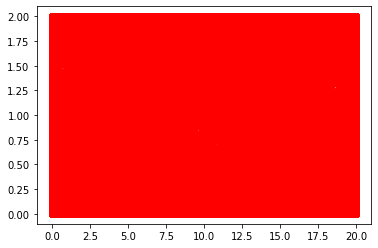

In [ ]:
plt.plot(x,y,'o',color = 'red')
plt.show()

In [ ]:
tf_x = tf.expand_dims(tf.convert_to_tensor(x),axis = 1)
tf_y = tf.expand_dims(tf.convert_to_tensor(y),axis = 1)
print(tf_x.shape)
print(tf_y.shape)

(120000, 1)
(120000, 1)


In [ ]:
input = tf.concat([tf_x,tf_y],axis = 1)
output1,output2 = PINN(input)

In [ ]:
np_output = tf.concat([output1,output2],axis = 1).numpy()

In [ ]:
print(np_output)

[[-0.00065306 -0.00081837]
 [-0.00065306 -0.00148731]
 [-0.00065306 -0.00070941]
 ...
 [-0.00065306 -0.00104702]
 [-0.00065306 -0.00127971]
 [-0.00065306 -0.00073314]]


In [ ]:
print(np_output.shape)
data2 = np.concatenate((np.expand_dims(x,axis = 1),np.expand_dims(y,axis = 1)),axis = 1)
print(data2.shape)

(120000, 2)
(120000, 2)


In [ ]:
data3 = data2 + 10000*np_output

Vẽ biến dạng

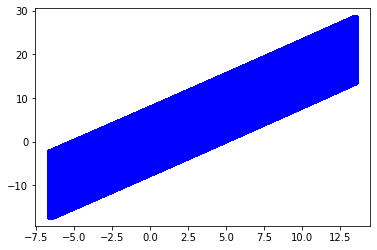

In [ ]:
plt.plot(data3[:,0],data3[:,1],'o',color = 'blue')
plt.show()